# BOLD rs-fMRI: confounds classifier

Are confounding variables, such as motion and global signals, capable of classifying AVGP from NVGP?

Below, we use a list of confounds extracted using fmriprep during preprocessing to predict subject group. Se expect to see a no significant difference from chance level as measured by prediction accuracy.

## Setup

To prepare the development environment, run:

```
mamba create -n tf
mamba activate tf
mamba install tensorflow-cpu nilearn matplotlib seaborn tqdm
pip install scikeras --no-deps
```

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nilearn.interfaces.bids import get_bids_files
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tqdm import tqdm

# from skopt import BayesSearchCV


## Prepare Data

In [113]:
confound_files = get_bids_files(
    'data/julia2018/derivatives/fmriprep_2020',
    # file_tag='timeseries',
    modality_folder='func',
    filters=[('ses', 'rest'), ('desc', 'confounds')],
    file_type='tsv')

_confounds_lst = []

for confound_file in confound_files:
    df = pd.read_csv(confound_file, sep='\t')
    df['timestep'] = df.index + 1
    df['subject'] = confound_file.split('/')[4].replace('sub-','')
    _confounds_lst.append(df)

confounds = pd.concat(_confounds_lst).reset_index(drop=True)

X = confounds.dropna(axis=1)
y = confounds['subject'].apply(lambda x: x[:4])

X_mean = confounds.groupby('subject').mean().drop(columns=['timestep']).dropna(axis=1)
y_mean = X_mean.index.to_series().apply(lambda x: x[:4])

## Pipeline and hyper-parameter tuning

In [114]:
pipe = Pipeline([
    ('zv', VarianceThreshold(0.0)),
    ('scale', StandardScaler()),
    ('select', SelectFromModel(SVC(kernel='linear'))),
    ('clf', SVC(kernel='linear', probability=True))
])

param_grid = {
    
}

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=3, scoring='accuracy', n_jobs=-1)

## Cross-validated model fitting

In [123]:
# hyper-parameter optimization
grid.fit(X_mean, y_mean)
model = grid.best_estimator_

# cross-validated model fitting

scores = []
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)

for train, test in tqdm(cv.split(X_mean, y_mean), total=cv.get_n_splits()):
    grid.best_estimator_.fit(X_mean.iloc[train], y_mean.iloc[train])
    score = grid.best_estimator_.score(X_mean.iloc[test], y_mean.iloc[test])
    scores.append(score)

print(f'score (mean/std): {np.mean(scores):.3f}/{np.std(scores):.3f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.429 total time=   0.0s
[CV 3/5] END ..................................., score=0.500 total time=   0.0s
[CV 2/5] END ..................................., score=0.286 total time=   0.0s
[CV 4/5] END ..................................., score=0.500 total time=   0.0s
[CV 5/5] END ..................................., score=0.167 total time=   0.0s


100%|██████████| 50/50 [00:00<00:00, 117.33it/s]

score (mean/std): 0.491/0.159


Let's also try a keras-based deep learning pipeline.

In [125]:
from tensorflow import keras
from scikeras.wrappers import KerasClassifier

def build_model(input_dim):
    clf = keras.models.Sequential()
    clf.add(keras.layers.Dense(10, activation='relu', input_dim=input_dim))
    clf.add(keras.layers.Dense(2, activation='softmax'))
    clf.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return clf

keras_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('clf', KerasClassifier(build_model, verbose=0, input_dim=X_mean.shape[1]))
])

# cross-validated model fitting
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)

keras_scores = []

y_mean_onehot = pd.get_dummies(y_mean)

for train, test in tqdm(cv.split(X_mean, y_mean), total=cv.get_n_splits()):
    keras_pipe.fit(X_mean.iloc[train], y_mean_onehot.iloc[train])
    score = keras_pipe.score(X_mean.iloc[test], y_mean_onehot.iloc[test])
    keras_scores.append(score)

print(f'validation score (mean/std): {np.mean(keras_scores):.3f}/{np.std(keras_scores):.3f}')


100%|██████████| 50/50 [00:18<00:00,  2.71it/s]

validation score (mean/std): 0.464/0.167


In [175]:
X_ts = X.groupby('subject').apply(lambda grp:
    np.stack(grp.sort_values('timestep').drop(columns=['timestep','subject']).values))

In [202]:
# fit a LSTM to the sequence of confounds

def build_lstm_model():
    model = keras.models.Sequential()
    n_timesteps = X_ts[0].shape[0]
    n_features = X_ts[0].shape[1]
    model.add(keras.layers.LSTM(10, input_shape=(n_timesteps, n_features)))
    model.add(keras.layers.Dense(2, activation='relu'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # print(model.summary())
    return model

lstm_pipe = KerasClassifier(build_lstm_model, verbose=0, epochs=100)

# cross-validated model fitting
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1)

lstm_scores = []

y_mean_onehot = pd.get_dummies(y_mean)

for train, test in tqdm(cv.split(X_ts, y_mean), total=cv.get_n_splits()):
    X_train = np.stack(X_ts.iloc[train])
    X_test = np.stack(X_ts.iloc[test])
    lstm_pipe.fit(X_train, y_mean_onehot.iloc[train])
    score = lstm_pipe.score(X_test, y_mean_onehot.iloc[test])
    lstm_scores.append(score)

print(f'validation score (mean/std): {np.mean(lstm_scores):.3f}/{np.std(lstm_scores):.3f}')



100%|██████████| 5/5 [00:26<00:00,  5.37s/it]

validation score (mean/std): 0.471/0.035


## Chance level

In [210]:
chance_model = DummyClassifier(strategy='most_frequent')

for train, test in tqdm(cv.split(X_mean, y_mean), total=cv.get_n_splits()):
    chance_model.fit(X_mean.iloc[train], y_mean.iloc[train])
    y_pred = chance_model.predict(X_mean.iloc[test])
    score = accuracy_score(y_mean.iloc[test], y_pred)
    scores.append(score)

print(f'chance score (mean/std): {np.mean(scores):.3f}/{np.std(scores):.3f}')

100%|██████████| 5/5 [00:00<00:00, 803.72it/s]

chance score (mean/std): 0.488/0.146


## Feature importance

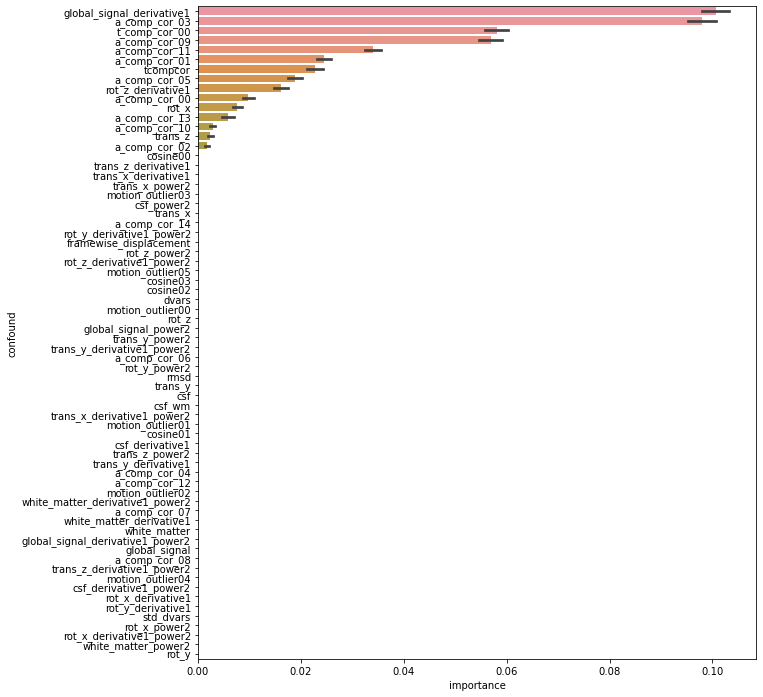

In [213]:
perm_results = permutation_importance(grid.best_estimator_,
                                      X_mean, y_mean,
                                      n_repeats=1000,
                                      scoring='accuracy',
                                      n_jobs=-1)

perm_importances = pd.DataFrame(perm_results.importances, index=X_mean.columns)

perm_importances = perm_importances.reset_index().rename(columns={'index':'confound'})
perm_importances = perm_importances.melt(
    id_vars=['confound'],
    var_name='cv_repetition',
    value_name='importance')

perm_importances['mean_importance'] = perm_importances.groupby('confound')['importance'].transform('mean')
perm_importances = perm_importances.sort_values(by='mean_importance', ascending=False)

_, ax = plt.subplots(1, 1, figsize=(10,12))
sns.barplot(data=perm_importances, x='importance', y='confound', orient='h', ax=ax)
plt.show()
